### *Localisation optimale des capacités de production éoliennes en Europe*

Notebook pour le  chargement des données du projet (partie I) -- version 1.2 (màj le 31/3/2020)

In [72]:
## imports classiques
import numpy as np

from cylp.cy import CyClpSimplex
from cylp.py.modeling.CyLPModel import CyLPArray, CyLPModel

import matplotlib.pyplot as plt
import math 
import pandas as pd
import plotly.graph_objects as go
import matplotlib.colors as colors
import random


colors_list = list(colors._colors_full_map.values())
random.shuffle(colors_list)

%matplotlib notebook

In [73]:
## paramètres

liste_pays = ['Allemagne','Autriche','Belgique','Danemark','Espagne','France','Irlande','Italie','Luxembourg',\
             'Norvège','Pays-Bas','Portugal','Royaume-Uni','Suède','Suisse']

liste_pays_index_dic = {'Allemagne':0,'Autriche':1,'Belgique':2,'Danemark':3,'Espagne':4,'France':5,'Irlande':6,'Italie':7,'Luxembourg':8,\
             'Norvège':9,'Pays-Bas':10,'Portugal':11,'Royaume-Uni':12,'Suède':13,'Suisse':14}

list_colors_dic = {'Allemagne':colors_list[0],'Autriche':colors_list[1],'Belgique':colors_list[2],'Danemark':colors_list[3],'Espagne':colors_list[4],\
                         'France':colors_list[5],'Irlande':colors_list[6],'Italie':colors_list[7],'Luxembourg':colors_list[8],\
             'Norvège':colors_list[9],'Pays-Bas':colors_list[10],'Portugal':colors_list[11],'Royaume-Uni':colors_list[12],'Suède':colors_list[13],'Suisse':colors_list[14]} 

TURB = np.array([8587 , 12009 , 1417 , 9 , 18372 , 25132 , 527 , 21117 , 1140 , 28941 , 37 , 5052 , 4269 , 16637 , 15101])
POMP = np.array([5223 , 3580 , 1307 , 0 , 5347 , 4303 , 292 , 7544 , 1100 , 1396 , 0 , 1029 , 2744 , 45 , 1636 ])
RES = np.array([0.3*1e6 , 3.2*1e6 , 0.01*1e6 , 0 , 18.4*1e6 , 9.8*1e6 , 0.24*1e6 , 7.9*1e6 , 0.005*1e6 , 84.147*1e6 , 0 , 2.6*1e6 , 1.2*1e6 , 33.756*1e6 , 8.4*1e6])

N_pays = 15                  # plus petit ou égal à N_pays_max = 15
N_sites = 642                # plus petit ou égal à sites_max = 642
N_heures_par_annee = 24*365  # nombre d'heures par année
N_annees = 1/12              # fraction de l'annee à utiliser ; prendre par exemple 1/12 pour tester sur un mois (calculs 
                             # plus rapides) ; dans le rapport il faut utiliser l'année complète N_annees = 1
N_heures = int(np.ceil(N_heures_par_annee*N_annees)) # nombre d'heures à extraire des fichiers de rendements

vecteur_temps = np.arange(1,N_heures+1) / N_heures_par_annee

In [74]:
## chargement et traitement des données brutes (I)
 
sites = pd.read_csv('Sites.csv')

onshore = sites[sites['capacite offshore']=='Non'].copy()
offshore = sites[sites['capacite offshore']=='Oui'].copy()

In [75]:
sites.head()

,index site,latitude,longitude,pays,couleur,capacite offshore,scores,capacites
0,1,54.0,8.0,Allemagne,#7b0323,Non,0.003291,7509.607003
1,2,54.0,9.0,Allemagne,#7b0323,Non,0.002193,5003.709632
2,3,54.0,10.0,Allemagne,#7b0323,Non,0.001852,4225.781588
3,4,54.0,11.0,Allemagne,#7b0323,Non,0.001852,4225.781588
4,5,54.0,12.0,Allemagne,#7b0323,Non,0.002193,5003.709632


In [76]:
onshore.head()

,index site,latitude,longitude,pays,couleur,capacite offshore,scores,capacites
0,1,54.0,8.0,Allemagne,#7b0323,Non,0.003291,7509.607003
1,2,54.0,9.0,Allemagne,#7b0323,Non,0.002193,5003.709632
2,3,54.0,10.0,Allemagne,#7b0323,Non,0.001852,4225.781588
3,4,54.0,11.0,Allemagne,#7b0323,Non,0.001852,4225.781588
4,5,54.0,12.0,Allemagne,#7b0323,Non,0.002193,5003.709632


In [77]:
offshore.head()

,index site,latitude,longitude,pays,couleur,capacite offshore,scores,capacites
487,0,54.0,7.0,Allemagne,#7b0323,Oui,0.006342,8364.150000
488,48,56.0,5.0,Danemark,#A9A9A9,Oui,0.010571,15478.589744
489,49,55.0,6.0,Allemagne,#7b0323,Oui,0.010571,13940.250000
490,61,52.0,3.0,Pays-Bas,#04d8b2,Oui,0.006342,2349.264706
491,66,58.0,10.0,Suède,#758da3,Oui,0.006342,8577.125000


In [78]:
"""# Visualisations des données pour les sites 

fig = go.Figure(data=go.Scattergeo(
        lon = offshore['longitude'],
        lat = offshore['latitude'],
        text = offshore['pays'],
        mode = 'markers',
        marker=dict(
        color = offshore['couleur'],
        size = offshore['scores']*1000)
        ))

fig.update_layout(
        title = 'Sites offshore, et leur importance',
        geo_scope = 'europe'
    )
fig.show();"""

"# Visualisations des données pour les sites \n\nfig = go.Figure(data=go.Scattergeo(\n        lon = offshore['longitude'],\n        lat = offshore['latitude'],\n        text = offshore['pays'],\n        mode = 'markers',\n        marker=dict(\n        color = offshore['couleur'],\n        size = offshore['scores']*1000)\n        ))\n\nfig.update_layout(\n        title = 'Sites offshore, et leur importance',\n        geo_scope = 'europe'\n    )\nfig.show();"

In [79]:
"""fig = go.Figure(data=go.Scattergeo(
        lon = onshore['longitude'],
        lat = onshore['latitude'],
        text = onshore['pays'],
        mode = 'markers',
        marker=dict(
        color = onshore['couleur'],
        size = onshore['scores']*3000)
        ))

fig.update_layout(
        title = 'Sites onshore, et leur importance',
        geo_scope = 'europe'
    )
fig.show();"""

"fig = go.Figure(data=go.Scattergeo(\n        lon = onshore['longitude'],\n        lat = onshore['latitude'],\n        text = onshore['pays'],\n        mode = 'markers',\n        marker=dict(\n        color = onshore['couleur'],\n        size = onshore['scores']*3000)\n        ))\n\nfig.update_layout(\n        title = 'Sites onshore, et leur importance',\n        geo_scope = 'europe'\n    )\nfig.show();"

In [80]:
"""fig = go.Figure(data=go.Scattergeo(
        lon = sites['longitude'],
        lat = sites['latitude'],
        text = sites['pays'],
        mode = 'markers',
        marker_color = sites['couleur'],
        marker = dict(size = 2),
        ))

fig.update_layout(
        title = 'Affectation par pays des sites éoliens',
        geo_scope = 'europe'
    )
fig.show();"""

"fig = go.Figure(data=go.Scattergeo(\n        lon = sites['longitude'],\n        lat = sites['latitude'],\n        text = sites['pays'],\n        mode = 'markers',\n        marker_color = sites['couleur'],\n        marker = dict(size = 2),\n        ))\n\nfig.update_layout(\n        title = 'Affectation par pays des sites éoliens',\n        geo_scope = 'europe'\n    )\nfig.show();"

In [81]:
"""fig = go.Figure(data=go.Scattergeo(
        lon = sites['longitude'],
        lat = sites['latitude'],
        text = 'pays: '+sites['pays']+', offshore: '+sites['capacite offshore']+' | capacite [MW] = '+\
        sites['capacites'].astype(str),
        mode = 'markers',
        marker = dict(
            color = sites['couleur'],
            size = sites['capacites']/sites['capacites'].max() * 30)
        ))

fig.update_layout(
        title = 'Capacites des sites éoliens',
        geo_scope = 'europe'
    )
fig.show();"""

"fig = go.Figure(data=go.Scattergeo(\n        lon = sites['longitude'],\n        lat = sites['latitude'],\n        text = 'pays: '+sites['pays']+', offshore: '+sites['capacite offshore']+' | capacite [MW] = '+        sites['capacites'].astype(str),\n        mode = 'markers',\n        marker = dict(\n            color = sites['couleur'],\n            size = sites['capacites']/sites['capacites'].max() * 30)\n        ))\n\nfig.update_layout(\n        title = 'Capacites des sites éoliens',\n        geo_scope = 'europe'\n    )\nfig.show();"

In [82]:
# chargement et traitement des données brutes (II)
rend_offshore_brut = np.genfromtxt('Rendements_offshore.csv', delimiter=',')[:,:N_heures]
rend_onshore_brut = np.genfromtxt('Rendements_onshore.csv', delimiter=',')[:,:N_heures]

print(rend_offshore_brut.shape)
print(rend_onshore_brut.shape)

(642, 730)
(642, 730)


In [83]:
indice_offshore= offshore["index site"]
rend_offshore_matrix = rend_offshore_brut[indice_offshore]
rend_offshore_array = np.array([np.sum(rend_offshore_matrix[i]) for i in range(len(indice_offshore))])


indice_onshore= onshore["index site"]
rend_onshore_matrix = rend_onshore_brut[indice_onshore]
rend_onshore_array = np.array([np.sum(rend_onshore_matrix[i]) for i in range(len(indice_onshore))])

maxoff= max(rend_offshore_array)
maxon = max(rend_onshore_array)

for i in range(len(rend_offshore_array)):
    if (rend_offshore_array[i] == max(rend_offshore_array) ) :
        print("Max offshore = {}  at  index = {} in offshore submatrix".format(maxoff,i))

for i in range(len(rend_onshore_array)):
    if (rend_onshore_array[i] == max(rend_onshore_array) ) : 
        print("Max onshore = {}  at  index = {} in onshore submatrix\n".format(maxon,i))
        
for i in range(642):
    if (rend_offshore_brut[i].sum() == maxoff):
        print("Max offshore = {}  at  index = {} in total matrix".format(maxoff,i))
    elif (rend_onshore_brut[i].sum() == maxon):
        print("Max onshore = {}  at  index = {} in total matrix".format(maxon,i))

Max offshore = 515.386574  at  index = 5 in offshore submatrix
Max onshore = 499.81911360000004  at  index = 62 in onshore submatrix

Max offshore = 515.386574  at  index = 67 in total matrix
Max onshore = 499.81911360000004  at  index = 69 in total matrix


In [84]:
rend_sites_matrix = rend_onshore_brut.copy()   # matrix combinant les valeurs réelles onshore/offshore -> souci de visibilité ci-dessous
for i in np.array(indice_offshore):
    rend_sites_matrix[i] = rend_offshore_brut[i]

print(rend_sites_matrix[443][0] == rend_offshore_brut[443][0])

True


In [85]:
#version pour le projet
#TODO contraince active, variable =0

s = CyClpSimplex()

T = 3 # pas de temps
kappa = 0.17
delta = 0.02


# Add variables
x = s.addVariable('x', N)

# Create coefficients and bounds
P=500000

# Add constraints
s += x >= 0

s += x.sum() == P


offshorearray = np.zeros(N_sites)
offshorearray[indice_offshore] = 1      # set à 1 les sites offshore 
s += (CyLPArray(offshorearray)*x) == kappa*P

n_interval = int(N_heures/T) - 1  # nombre d'intervalle sur les heures imparties
L = s.addVariable('l', n_interval)  # vecteur T de longeur n_interval pour gérer valeurs absolues 
s += L.sum() <= delta*P*n_interval # contrainte de variabilité

total = np.zeros(N_sites)
#TODO sum 1) sum2
for n in range (n_interval):
    for k in range(N):
        rend1_sum =0
        rend2_sum = 0
        for i in range (T*n, T*n+T):
            rend1_sum += rend_sites_matrix[k][i]
            rend2_sum += rend_sites_matrix[k][i+T]
        total[k] = CyLPArray(rend1_sum) - CyLPArray(rend2_sum)
    total= CyLPArray(total)
    s += total*x - L[n] <= 0
    s += -total*x - L[n] <= 0



#print ("\nConstraints :\n", s.constraints)
#print ("\nConstraintMatrix :\n", s.coefMatrix)

# Set the objective function
c_off= -CyLPArray(rend_offshore_array)   # rendements associés aux sites offshore
c_on = -CyLPArray(rend_onshore_array)    # rendements associés aux sites onshore

s.objective = c_off * x[np.array(indice_offshore)] + c_on * x[np.array(indice_onshore)]    #n'accepte pas les types : pandas.series
#print("\nc = ",s.objective)

# Solve using primal Simplex
s.primal()

## Solutions ##

PUISSANCE_INSTALLEE = s.primalVariableSolution['x']
ENERGIE_TOTALE = -s.objectiveValue

#print ("\nlsol = ",s.primalVariableSolution['l']) 
print ("\nxsol = ",PUISSANCE_INSTALLEE) 
print("\nObjVal = ", ENERGIE_TOTALE)
print("\nSOL OPTIMALE ? = ", s.getStatusString())
print(s.primalVariableSolution['x'].sum())
print(s.primalVariableSolution['x'][indice_offshore].sum())


xsol =  [0.00000000e+00 5.68031485e+02 1.85896075e+04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.15918380e+03
 2.49957114e+04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.12146258e+03 0.00000000e+00 1.42275346e+04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.29207611e+04 3.32531751e+03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.06302527e+03 0.00000000e+00 0.00000000e+00
 3.88027114e+02

In [86]:
print("Rendement moyen sur une année :", ENERGIE_TOTALE/(N_heures*500000))

Rendement moyen sur une année : 0.5297368204847486


In [96]:
#TODO faire un dataframe panda pour classer les 10 meilleurs sites selon leurs rendements moyen sur l'année

dict = {}
for i in range(len(rend_sites_matrix)):
    dict[i] = rend_sites_matrix[i].sum()

dict_sorted = sorted(dict.items(), key=lambda x: x[1],reverse=True)
dict_best = dict_sorted[:10]

index_best = np.zeros(10)
rendement_best = np.zeros(10)
for i in range(10):
    index_best[i] = dict_best[i][0]
    rendement_best[i]=dict_best[i][1]
print(index_best)

classement = pd.DataFrame([],columns = sites.columns)

for i in range(10):
    ligne = sites[sites["index site"]==index_best[i]]
    classement.append(ligne)
print(classement)
        
        
        
    
"""print(rendement_best/N_heures)


sites_best = sites[sites['index site'] == index_best].copy()



mask = famille_panda_df["ventre"]==80
pandas_80 = famille_panda_df[mask]"""



[ 67.  68.  69.   2. 408.  75. 399.  73.  74.   0.]
Empty DataFrame
Columns: [index site, latitude, longitude, pays, couleur, capacite offshore, scores, capacites]
Index: []


'print(rendement_best/N_heures)\n\n\nsites_best = sites[sites[\'index site\'] == index_best].copy()\n\n\n\nmask = famille_panda_df["ventre"]==80\npandas_80 = famille_panda_df[mask]'

In [60]:
famille_panda = [[100, 5  , 20, 80],
                 [50 , 2.5, 10, 40],
                 [110, 6  , 22, 80],]

## Créons un DataFrame ##
famille_panda_df = pd.DataFrame(famille_panda,
                                index= ["maman","bebe","bapa"],
                                columns=["pattes", "poils","queue","ventre"])
famille_panda_df

,pattes,poils,queue,ventre
maman,100,5.0,20,80
bebe,50,2.5,10,40
bapa,110,6.0,22,80


il y a 80 sites éoliens en France


NameError: name 'matrice_rendements_onshore' is not defined

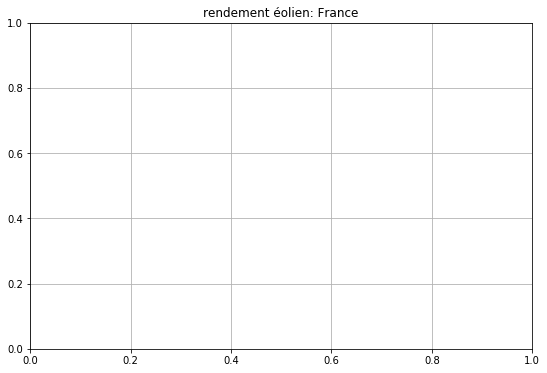

In [38]:
## Visualisation des rendements pour un pays

pays_test = 'France'
index_test = liste_pays_index_dic[pays_test]

# nombre de sites éoliens
index_sites_eoliens = sites[sites.pays==pays_test]['index site']
n_eoliens = len(index_sites_eoliens)
print('il y a '+str(n_eoliens)+' sites éoliens en '+str(pays_test))

# rendements eolien au hasard
random_site = np.random.choice(index_sites_eoliens)
plt.figure(figsize=(9,6))
plt.grid()
plt.title('rendement éolien: '+str(pays_test))
if sites.loc[random_site]['capacite offshore']=='Oui':
    plt.plot(vecteur_temps,matrice_rendements_offshore[random_site])
    plt.legend(['offshore'])
else:
    plt.plot(vecteur_temps,matrice_rendements_onshore[random_site])
    plt.legend(['onshore'])
plt.xlabel('temps : [années]')
plt.ylabel('rendement éolien: [/]')

print('rendement moyen offshore pour le pays: '+str(np.mean(matrice_rendements_offshore[index_sites_eoliens])))
print('rendement moyen onshore pour le pays: '+str(np.mean(matrice_rendements_onshore[index_sites_eoliens])))

# capacité éoliennes maximales tolérables
buf_ok_offshore = (sites.pays==pays_test) & (sites['capacite offshore']=='Oui')
buf_ok_onshore = (sites.pays==pays_test) & (sites['capacite offshore']=='Non')

print(' => capacité éolienne totale offshore : [MW] '+str(sites[buf_ok_offshore]['capacites'].sum()))
print(' => capacité éolienne totale offshore : [MW] '+str(sites[buf_ok_onshore]['capacites'].sum()))

# latitude/longitude
print('le pays '+str(pays_test)+' se trouve  à une latitude de '+str(sites.loc[random_site]['latitude'])+' et une longitude de '+\
      str(sites.loc[random_site]['longitude']))